In [ ]:
%tensorflow_version 1.x
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pickle
import csv
import numpy as np
import tensorflow as tf
import pandas as pd
import httplib2
import os
import requests

In [ ]:
from __future__ import division, print_function, unicode_literals

In [ ]:
np.random.seed(101)
tf.set_random_seed(101)

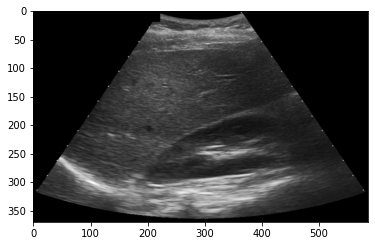

In [ ]:
I = plt.imread('1.bmp')
plt.imshow(I,cmap='gray')

In [ ]:
from PIL import Image
image_size1 = 252
image_size2 = 400

# load your images here
# into "Data" numpy array with shape: (num , image_size1 ,  image_size2)

# load your labels here
# into "label" numpy array with shape: (num , )


In [ ]:
tf.reset_default_graph()

X_input = tf.placeholder(shape=[None, image_size1, image_size2], dtype=tf.float32)
y_true = tf.placeholder(shape=[None , 2], dtype = tf.float32)

In [ ]:
def init_weights(shape):
  init_random_dist = tf.truncated_normal(shape , stddev = 0.1)
  return tf.Variable(init_random_dist)

def init_bias(shape):
  init_bias_vals = tf.constant(0.1 , shape = shape)
  return tf.Variable(init_bias_vals)

In [ ]:
conv1_params = {
    "filters": 96,
    "kernel_size": 15,
    "strides": 4,
    "padding": "SAME",
    "activation": tf.nn.relu,
}

conv2_params = {
    "filters": 48,
    "kernel_size": 7,
    "strides": 1,
    "padding": "SAME",
    "activation": tf.nn.relu
}

conv3_params = {
    "filters": 256,
    "kernel_size": 3,
    "strides": 1,
    "padding": "SAME",
    "activation": tf.nn.relu
}

conv4_params = {
    "filters": 192,
    "kernel_size": 3,
    "strides": 1,
    "padding": "SAME",
    "activation": tf.nn.relu
}

conv5_params = {
    "filters": 192,
    "kernel_size": 3,
    "strides": 1,
    "padding": "SAME",
    "activation": tf.nn.relu
}

pool1_params = {
    "ksize" : [1,3,3,1],
    "strides" : [1,2,2,1],
    "padding" : "SAME"
}

pool2_params = {
    "ksize" : [1,2,2,1],
    "strides" : [1,1,1,1],
    "padding" : "SAME"
}

pool5_params = {
    "ksize" : [1,3,3,1],
    "strides" : [1,2,2,1],
    "padding" : "SAME"
}

In [ ]:
x_image = tf.reshape(X_input , [-1,image_size1,image_size2,1])
conv1 = tf.layers.conv2d(x_image, **conv1_params)
norm1 = tf.nn.local_response_normalization(conv1)
pool1 = tf.nn.max_pool(norm1, **pool1_params)
conv2 = tf.layers.conv2d(pool1, **conv2_params)
norm2 = tf.nn.local_response_normalization(conv2)
pool2 = tf.nn.max_pool(norm2, **pool2_params)
conv3 = tf.layers.conv2d(pool2, **conv3_params)
conv4 = tf.layers.conv2d(conv3, **conv4_params)
conv5 = tf.layers.conv2d(conv4, **conv5_params)
pool5 = tf.nn.max_pool(conv5, **pool5_params)

flat = tf.reshape(pool5 , [-1, np.prod(pool5.get_shape().as_list()[1:])])

In [ ]:
input_size = (int)(flat.get_shape()[1])
W1 = init_weights([input_size , 4096])
b1 = init_bias([4096])
fc1 = tf.matmul(flat , W1) + b1

W2 = init_weights([4096 , 4096])
b2 = init_bias([4096])
fc2 = tf.matmul(fc1 , W2) + b2

W3 = init_weights([4096 , 2])
b3 = init_bias([2])
y_pred = tf.matmul(fc2 , W3) + b3

In [ ]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=y_pred,))
regularizer = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3);
beta = 0.000001
loss = cross_entropy + beta * regularizer

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001)
train = optimizer.minimize(loss)

In [ ]:
init = tf.global_variables_initializer()

In [ ]:
label_oh = np.zeros(shape=(np.size(label,0),2))
for i in range(np.size(label,0)):
  label_oh[i,label[i]] = 1
label = label_oh

In [ ]:
# devide (Data, label) into train-test sets

# Train = ?
# TrainLabel = ?
# Test = ?
# TestLabel = ?

In [ ]:
def getNextBatch(batch_size):
  N = np.size(Train,0)
  idx = np.random.randint(0,N,batch_size)
  batchLabel = TrainLabel[idx]
  return Train[idx,:,:]  , batchLabel.astype('uint8')

In [ ]:
saver = tf.train.Saver()

In [ ]:
steps = 10
step_disp = 10
valid_acc = np.zeros(shape = (steps // step_disp))
cnt = 0

restore_checkpoint = True
checkpoint_path = "./checkpoint/"

save_model = False

with tf.Session() as sess:
  if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
    saver.restore(sess, checkpoint_path)
  else:
    print('checkpoint not loaded!')
    sess.run(init)
  
  for i in range(steps):
    Xbatch , Ybatch = getNextBatch(10)
    sess.run(train , feed_dict = {X_input: Xbatch , y_true: Ybatch})
    
    if i % step_disp == 0 :
      matches = tf.equal(tf.argmax(y_pred,1) , tf.argmax(y_true,1))
      acc = tf.reduce_mean(tf.cast(matches , tf.float32))
      Accuracy = (sess.run(acc , feed_dict={X_input : Test, y_true : TestLabel})*100)
      print("step:",str(i),"from",str(steps),"validation accuracy is: %.2f" % Accuracy,"%")
      valid_acc[cnt] = Accuracy
      cnt = cnt + 1
  
  if save_model:
      save_path = saver.save(sess, checkpoint_path)

  # If you want to extract features using this network, uncomment the following two lines:
  # Features = sess.run(fc2 , feed_dict={X_input : Data, y_true : label})
  # np.savetxt("/content/gdrive/My Drive/Mirzaei/109/Features109-2-fc2m.csv", Features, delimiter=",")

  print('_' * 50)
  print("final test accuracy is: %.2f" % (sess.run(acc , feed_dict={X_input : Data, y_true : label})*100),"%")

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Mirzaei/109/
step: 0 from 1 validation accuracy is: 100.00 %


IndexError: ignored